In [38]:
import pandas as pd
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import IL
from censusdis.counties.illinois import COOK

from pathlib import Path

import divintseg as dis
import time

## Setup

In [39]:
CENSUS_API_KEY = None
DATASET = "dec/pl"
GROUP = "P1"

# Census tracts consist of a 4 digit identifier within county, and then an optional 2 digit suffix
tracts_near_north = [
    '080100',
    '080201',
    '080202',
    '080300',
    '080400',
    '842200',
    '081000',
    '081100',
    '081201',
    '081202',
    '081300',
    '081401',
    '081402',
    '081403',
    '081500',
    '081600',
    '081700',
    '081800',
    '081900',
    '838300',
]

## Download the data for Near North

In [40]:
df_stacked = pd.DataFrame()

for year in [2010, 2020]:
    df_near_north = ced.download(
        dataset=DATASET,
        vintage=year,
        leaves_of_group=GROUP,
        state=IL,
        county=COOK,
        tract=tracts_near_north,
        block='*',
        api_key=CENSUS_API_KEY,
    )

    df_near_north_final = dis.di(
        df_communities=df_near_north,
        by=['STATE', 'COUNTY', 'TRACT'], 
        over='BLOCK'
    ).reset_index()

    df_near_north_final['year'] = year
    df_stacked = pd.concat([df_stacked, df_near_north_final]) 

c:\Users\bcong\Dropbox\github\near-north-demographics\.venv\Lib\site-packages\divintseg\_core.py:169: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_communities.groupby(by=by).apply(integration_of_group),
c:\Users\bcong\Dropbox\github\near-north-demographics\.venv\Lib\site-packages\divintseg\_core.py:169: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_communities.groupby(by=by).apply(integration_of_group),


## Wrangle 2000 separately

In [41]:
df_near_north_2000 = pd.read_csv(Path(Path.cwd() / 'data' / 'census_2000.csv'))

# 2000 census tracts: https://www.chicago.gov/content/dam/city/depts/zlup/Zoning_Main_Page/Publications/Census_2000_Community_Area_Profiles/PDF_08.pdf
tracts_near_north_2000 = [t for t in range(80100, 82000, 100)]

df_near_north_2000 = df_near_north_2000.query(
    'TRACTA in @tracts_near_north_2000'
)

df_near_north_2000 = df_near_north_2000[
    [
        'STATEA',
        'COUNTYA',
        'TRACTA',
        'BLOCKA',
        'FYE001',
        'FYE002',
        'FYE003',
        'FYE004',
        'FYE005',
        'FYE006',
        'FYE007'
    ]
]

C:\Users\bcong\AppData\Local\Temp\ipykernel_29940\2040317487.py:1: DtypeWarning: Columns (13,28,29,30,33,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_near_north_2000 = pd.read_csv(Path(Path.cwd() / 'data' / 'census_2000.csv'))


In [42]:
df_near_north_2000.head(10)

,STATEA,COUNTYA,TRACTA,BLOCKA,FYE001,FYE002,FYE003,FYE004,FYE005,FYE006,FYE007
36551,17,31.0,80100,1000,0,0,0,0,0,0,0
36552,17,31.0,80100,1001,0,0,0,0,0,0,0
36553,17,31.0,80100,1002,726,9,0,12,0,16,6
36554,17,31.0,80100,1003,152,0,0,0,0,0,0
36555,17,31.0,80100,1004,497,12,3,14,0,14,3
36556,17,31.0,80100,1005,1011,35,1,47,1,9,5
36557,17,31.0,80100,1006,0,0,0,0,0,0,0
36558,17,31.0,80100,1007,0,0,0,0,0,0,0
36559,17,31.0,80100,1008,0,0,0,0,0,0,0
36560,17,31.0,80100,1009,0,0,0,0,0,0,0


In [43]:
# Wrangle to stack with the other data
df_near_north_2000_final = df_near_north_2000.rename(columns={
    'STATEA': 'STATE',
    'COUNTYA': 'COUNTY',
    'TRACTA': 'TRACT',
    'BLOCKA': 'BLOCK'
})

df_near_north_2000_final['COUNTY'] = df_near_north_2000_final['COUNTY'].astype(int)

df_near_north_2000_final['STATE'] = df_near_north_2000_final['STATE'].apply(lambda x: f"{x:02}")
df_near_north_2000_final['COUNTY'] = df_near_north_2000_final['COUNTY'].apply(lambda x: f"{x:03}")
df_near_north_2000_final['TRACT'] = df_near_north_2000_final['TRACT'].apply(lambda x: f"{x:06}")

df_near_north_2000_final = dis.di(
    df_communities=df_near_north_2000_final,
    by=['STATE', 'COUNTY', 'TRACT'], 
    over='BLOCK'
).reset_index()

df_near_north_2000_final['year'] = 2000

df_stacked = pd.concat([df_stacked, df_near_north_2000_final]).sort_values(by='year')

df_stacked.head(10)

c:\Users\bcong\Dropbox\github\near-north-demographics\.venv\Lib\site-packages\divintseg\_core.py:169: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_communities.groupby(by=by).apply(integration_of_group),


,STATE,COUNTY,TRACT,diversity,integration,year
8,17,031,080900,0.602725,0.591100,2000
9,17,031,081000,0.404648,0.360712,2000
10,17,031,081100,0.373200,0.333548,2000
11,17,031,081200,0.193304,0.183942,2000
12,17,031,081300,0.275336,0.250047,2000
13,17,031,081400,0.386537,0.376450,2000
14,17,031,081500,0.321367,0.309486,2000
15,17,031,081600,0.354853,0.348596,2000
0,17,031,080100,0.135256,0.133233,2000
1,17,031,080200,0.207206,0.205483,2000


## Compute diversity and integration

TODO: add explanation of diversity/integration from `divintseg`

## Plot

In [44]:
df_stacked = ced.add_inferred_geography(df_stacked, 2020)

In [45]:
df_stacked.head(10)

,STATE,COUNTY,TRACT,diversity,integration,year,geometry
0,17,031,080900,0.602725,0.591100,2000,None
1,17,031,081000,0.404648,0.360712,2000,"POLYGON ((-87.63448 41.90385, -87.633 41.90388..."
2,17,031,081100,0.373200,0.333548,2000,"POLYGON ((-87.62999 41.90392, -87.62868 41.903..."
3,17,031,081200,0.193304,0.183942,2000,None
4,17,031,081300,0.275336,0.250047,2000,"POLYGON ((-87.6241 41.89839, -87.62413 41.8992..."
5,17,031,081400,0.386537,0.376450,2000,None
6,17,031,081500,0.321367,0.309486,2000,"POLYGON ((-87.6282 41.89668, -87.62685 41.8967..."
7,17,031,081600,0.354853,0.348596,2000,"POLYGON ((-87.62978 41.89666, -87.6282 41.8966..."
8,17,031,080100,0.135256,0.133233,2000,"POLYGON ((-87.62889 41.91122, -87.62573 41.911..."
9,17,031,080200,0.207206,0.205483,2000,None


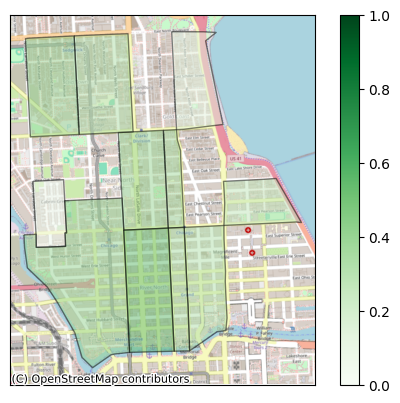

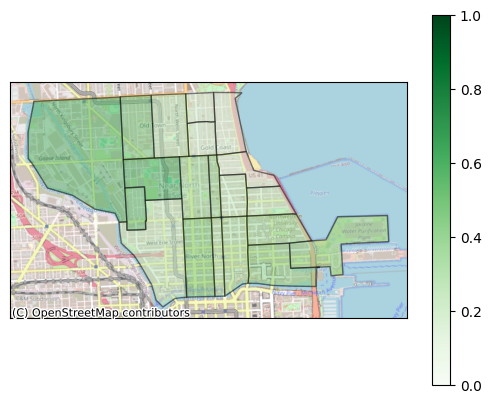

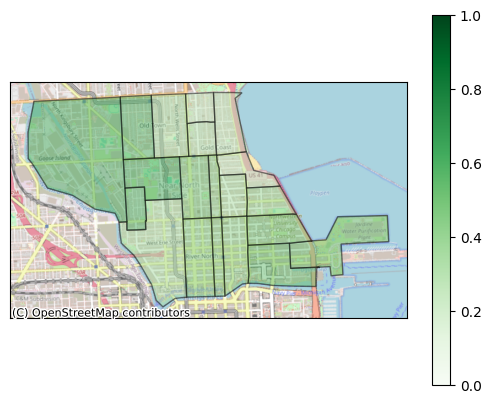

In [46]:
for year in [2000, 2010, 2020]:
    df_to_plot = df_stacked[df_stacked['year'] == year]
    ax = cem.plot_map(
        df_to_plot,
        "diversity",
        cmap="Greens",
        edgecolor="black",
        alpha=0.5,
        with_background=True,
        legend=True,
        vmin=0.0,
        vmax=1.0,
    )